In [38]:
import torch
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms as T
from augment_functions import resize_encoder, random_mask, augment_sample, augment_sample_random_mask
from matern_kernel import matern_kernel_noise_batch

In [39]:
def add_matern_kernel_noise_batch(sample, nu=2.5, lengthscale=1.0, sigma=1.0):
    B, C, H, W = sample.shape
    x = torch.linspace(0, 1, W, device=sample.device)
    y = torch.linspace(0, 1, H, device=sample.device)
    xx, yy = torch.meshgrid(x, y, indexing="xy")
    coords = torch.stack([xx.flatten(), yy.flatten()], dim=1)
    noise = matern_kernel_noise_batch(
        sample=sample,
        coords=coords,
        nu=nu,
        lengthscale=lengthscale,
        sigma=sigma,
    )
    return sample + noise, noise

In [40]:
# Simple Gaussian Noise for Comparison
def add_noise(sample, ref_noise):
    sigma = ref_noise.std()
    noise = torch.randn(size=sample.shape) * sigma
    return sample + noise

In [41]:
class WeatherBenchDataset(Dataset):
    def __init__(self, data, mask_prob=0.7):
        self.data = data
        self.mask_prob = mask_prob
        
    def __len__(self):
        return (self.data.shape[0])

    def __getitem__(self, idx):
        x_orig = self.data[idx]
        x = resize_encoder(x_orig)
        masked_x = random_mask(x, mask_prob=self.mask_prob)
        X = augment_sample(x_orig)
        X_prime = augment_sample_random_mask(x_orig, random_mask_prob=self.mask_prob)
        return x, masked_x, X, X_prime

In [42]:
BATCH_SIZE = 1

data = torch.load('/vol/bitbucket/nb324/ERA5_64x32_daily_850.pt')
n_samples = data.shape[0]
n_train = int(n_samples * 0.6)

train_data = data[:n_train]

mean = train_data.mean(dim=(0, 2, 3), keepdim=True)
std = train_data.std(dim=(0, 2, 3), keepdim=True)
train_data = (train_data - mean) / std
train_dataset = WeatherBenchDataset(data=train_data, mask_prob=0.7)
trainloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

In [43]:
batch = next(iter(trainloader))

X_noise, noise = add_matern_kernel_noise_batch(batch[2])

X_gaussian = add_noise(batch[2], noise)

X = batch[2][0]
X_noise = X_noise[0]
X_gaussian = X_gaussian[0]
X_prime = batch[3][0]

X = X[0, :, :].T
X_noise = X_noise[0, :, :].T
X_gaussian = X_gaussian[0, :, :].T
X_prime = X_prime[0, :, :].T


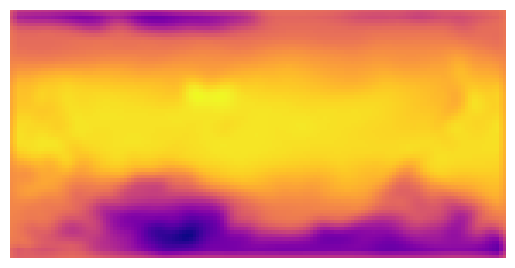

In [44]:
plt.axis('off')
plt.imshow(X, cmap='plasma')

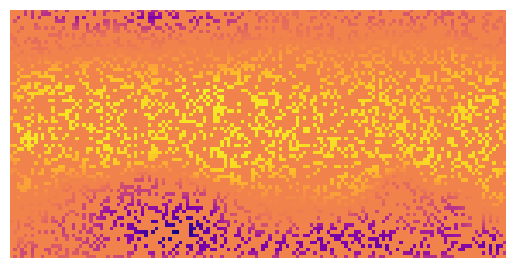

In [45]:
plt.axis('off')
plt.imshow(X_prime, cmap='plasma')

Text(0.5, 1.0, 'Matern Noise Added')

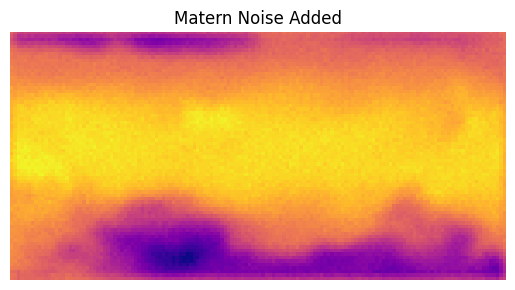

In [46]:
# Add Matern Noise to the sample
plt.axis('off')
plt.imshow(X_noise, cmap='plasma')
plt.title("Matern Noise Added")

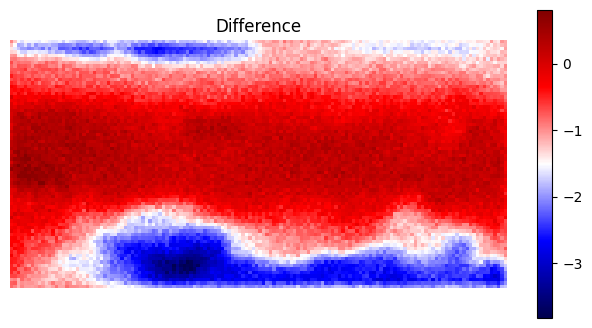

In [47]:
diff = (X_noise - X)
plt.figure(figsize=(8, 4))
im = plt.imshow(diff, cmap='seismic')
plt.title("Difference")
plt.colorbar(im)
plt.axis('off')
plt.show()

Text(0.5, 1.0, 'Gaussian Noise Added')

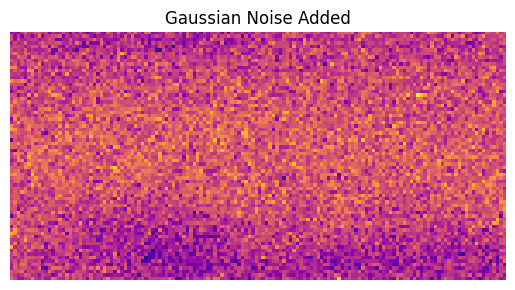

In [48]:
# Add Matern Noise to the sample
plt.axis('off')
plt.imshow(X_gaussian, cmap='plasma')
plt.title("Gaussian Noise Added")

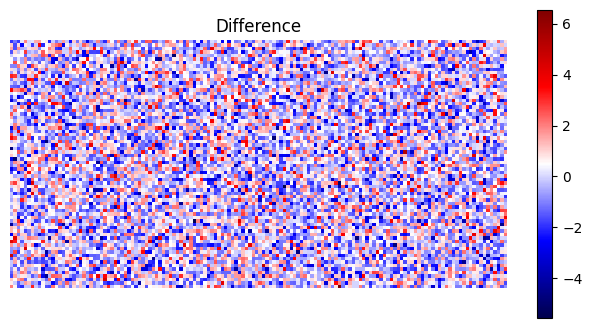

In [49]:
diff = (X_gaussian - X)
plt.figure(figsize=(8, 4))
im = plt.imshow(diff, cmap='seismic')
plt.title("Difference")
plt.colorbar(im)
plt.axis('off')
plt.show()